# IMPORTS

---



In [ ]:
"""
Cell 1: Import all necessary libraries
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque, Counter
import random
import pickle
import os
import gc
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# For memory monitoring
try:
    import psutil
    def print_memory_usage():
        process = psutil.Process()
        mem_gb = process.memory_info().rss / 1024**3
        print(f"💾 RAM Usage: {mem_gb:.2f} GB")
except:
    def print_memory_usage():
        print("💾 psutil not available - install with: !pip install psutil")

print("✓ All libraries imported successfully")
print_memory_usage()

✓ All libraries imported successfully
💾 RAM Usage: 0.23 GB


# MOUNTING DRIVE

In [7]:
"""
Cell 2: Mount Google Drive and create project directories
"""

from google.colab import drive

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create project directory structure
project_base = '/content/drive/MyDrive/Data' # <-- Assign a value here
paths = {
    'base': project_base,
    'corpus': f'{project_base}/corpus.txt',      # TRAINING DATA
    'test': f'{project_base}/test.txt',          # TEST DATA
    'models': f'{project_base}/models',
    'checkpoints': f'{project_base}/checkpoints',
    'results': f'{project_base}/results'
}

# Create directories if they don't exist
for key in ['models', 'checkpoints', 'results']:
    os.makedirs(paths[key], exist_ok=True)
    print(f"✓ Created/verified: {paths[key]}")

print("\n" + "="*60)
print("PATHS CONFIGURED:")
print("="*60)
for key, path in paths.items():
    print(f"{key:12s}: {path}")
print("="*60)

print("\n⚠️ IMPORTANT: Upload these files to Google Drive:")
print(f"   📁 {paths['corpus']}  (TRAINING - 50,000 words)")
print(f"   📁 {paths['test']}    (TESTING - for evaluation)")
print("\nIf your files are in different locations, update the paths above.")

Mounting Google Drive...
Mounted at /content/drive
✓ Created/verified: /content/drive/MyDrive/Data/models
✓ Created/verified: /content/drive/MyDrive/Data/checkpoints
✓ Created/verified: /content/drive/MyDrive/Data/results

PATHS CONFIGURED:
base        : /content/drive/MyDrive/Data
corpus      : /content/drive/MyDrive/Data/corpus.txt
test        : /content/drive/MyDrive/Data/test.txt
models      : /content/drive/MyDrive/Data/models
checkpoints : /content/drive/MyDrive/Data/checkpoints
results     : /content/drive/MyDrive/Data/results

⚠️ IMPORTANT: Upload these files to Google Drive:
   📁 /content/drive/MyDrive/Data/corpus.txt  (TRAINING - 50,000 words)
   📁 /content/drive/MyDrive/Data/test.txt    (TESTING - for evaluation)

If your files are in different locations, update the paths above.


# PREPROCESSING

In [ ]:
"""
Cell 3: Functions to load and preprocess corpus and test data
"""

def load_corpus(filepath, min_length=2, max_length=20):

    print(f"Loading data from: {filepath}")
    words = []

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip().lower()
                # Filter: only alphabetic words within length range
                if min_length <= len(word) <= max_length and word.isalpha():
                    words.append(word)

        print(f"✓ Loaded {len(words):,} words")
        return words

    except FileNotFoundError:
        print(f"❌ ERROR: File not found at {filepath}")
        print("Please upload the file to the correct location!")
        return []

def group_words_by_length(words):
    """
    Group words by length for efficient HMM training
    (Each word length gets its own HMM)

    Returns:
        dict: {word_length: [list of words]}
    """
    grouped = defaultdict(list)
    for word in words:
        grouped[len(word)].append(word)

    result = dict(grouped)

    print(f"\n{'='*60}")
    print("WORD LENGTH DISTRIBUTION:")
    print(f"{'='*60}")
    for length in sorted(result.keys()):
        print(f"  Length {length:2d}: {len(result[length]):6,} words")
    print(f"{'='*60}")

    return result

def analyze_corpus(words, dataset_name="Dataset"):
    """
    Print useful statistics about the corpus
    """
    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} STATISTICS:")
    print(f"{'='*60}")
    print(f"  Total words: {len(words):,}")
    print(f"  Unique words: {len(set(words)):,}")
    print(f"  Shortest word: '{min(words, key=len)}' ({len(min(words, key=len))} letters)")
    print(f"  Longest word: '{max(words, key=len)}' ({len(max(words, key=len))} letters)")
    print(f"  Average length: {np.mean([len(w) for w in words]):.2f} letters")

    # Letter frequency
    all_letters = ''.join(words)
    letter_freq = Counter(all_letters)
    top_5 = letter_freq.most_common(5)
    print(f"\n  Top 5 most common letters:")
    for letter, count in top_5:
        pct = (count / len(all_letters)) * 100
        print(f"    '{letter}': {count:,} ({pct:.2f}%)")
    print(f"{'='*60}")

# Test the functions (will actually load in next cell)
print("✓ Data loading functions defined successfully")
print("\n📝 NOTE: We will:")
print("  • TRAIN HMM and RL Agent on corpus.txt")
print("  • EVALUATE final agent on test.txt (2000 games)")

✓ Data loading functions defined successfully

📝 NOTE: We will:
  • TRAIN HMM and RL Agent on corpus.txt
  • EVALUATE final agent on test.txt (2000 games)


In [ ]:
"""
Cell 4: Load training corpus and test data
"""

print("="*60)
print("LOADING DATA")
print("="*60)

# Load training corpus (for HMM and RL training)
print("\n[1/2] Loading TRAINING data (corpus.txt)...")
corpus_words = load_corpus(paths['corpus'], min_length=2, max_length=20)

if len(corpus_words) == 0:
    print("\n❌ FAILED: Could not load corpus.txt")
    print("Please check the file path and try again!")
else:
    analyze_corpus(corpus_words, dataset_name="TRAINING CORPUS")

    # Group by length for HMM training
    corpus_grouped = group_words_by_length(corpus_words)

    print(f"\n✓ Training corpus ready: {len(corpus_words):,} words")
    print_memory_usage()

# Load test data (for final evaluation)
print("\n" + "="*60)
print("\n[2/2] Loading TEST data (test.txt)...")
test_words = load_corpus(paths['test'], min_length=2, max_length=20)

if len(test_words) == 0:
    print("\n⚠️ WARNING: Could not load test.txt")
    print("Will use a subset of corpus for testing (not recommended)")
    # Check if corpus_words is not empty before sampling
    if corpus_words:
        test_words = random.sample(corpus_words, min(2000, len(corpus_words)))
    else:
        test_words = [] # Ensure test_words is an empty list if corpus_words is empty
else:
    analyze_corpus(test_words, dataset_name="TEST SET")
    print(f"\n✓ Test set ready: {len(test_words):,} words")

print("\n" + "="*60)
print("DATA LOADING COMPLETE")
print("="*60)
print(f"📊 Training words: {len(corpus_words):,}")
print(f"📊 Test words: {len(test_words):,}")
# Only print word lengths if corpus_grouped is defined and not empty
if 'corpus_grouped' in locals() and corpus_grouped:
    print(f"📊 Word lengths in corpus: {min(corpus_grouped.keys())} to {max(corpus_grouped.keys())}")
print("="*60)
print_memory_usage()

# Check for overlap (ideally should be minimal)
# Only check overlap if both lists are not empty
if corpus_words and test_words:
    overlap = set(corpus_words) & set(test_words)
    if overlap:
        overlap_pct = (len(overlap) / len(test_words)) * 100
        print(f"\n⚠️ Note: {len(overlap)} words ({overlap_pct:.1f}%) appear in both training and test sets")
    else:
        print("\n✓ No overlap between training and test sets (ideal!)")
elif not corpus_words and not test_words:
    print("\n⚠️ Cannot check overlap: Both training and test sets are empty.")
elif not corpus_words:
    print("\n⚠️ Cannot check overlap: Training set is empty.")
else: # not test_words
    print("\n⚠️ Cannot check overlap: Test set is empty.")

LOADING DATA

[1/2] Loading TRAINING data (corpus.txt)...
Loading data from: /content/drive/MyDrive/Data/corpus.txt
✓ Loaded 49,905 words

TRAINING CORPUS STATISTICS:
  Total words: 49,905
  Unique words: 49,346
  Shortest word: 'pf' (2 letters)
  Longest word: 'benzofuroquinoxaline' (20 letters)
  Average length: 9.50 letters

  Top 5 most common letters:
    'e': 49,166 (10.37%)
    'a': 42,043 (8.87%)
    'i': 41,980 (8.86%)
    'o': 35,720 (7.54%)
    'r': 33,536 (7.07%)

WORD LENGTH DISTRIBUTION:
  Length  2:     84 words
  Length  3:    388 words
  Length  4:  1,169 words
  Length  5:  2,340 words
  Length  6:  3,755 words
  Length  7:  5,111 words
  Length  8:  6,348 words
  Length  9:  6,787 words
  Length 10:  6,465 words
  Length 11:  5,452 words
  Length 12:  4,292 words
  Length 13:  3,094 words
  Length 14:  2,019 words
  Length 15:  1,226 words
  Length 16:    698 words
  Length 17:    375 words
  Length 18:    174 words
  Length 19:     88 words
  Length 20:     40 words

# DEFINING HMM

In [ ]:
"""
Cell 5: Hidden Markov Model Implementation (Pickle-compatible)
"""

class HiddenMarkovModel:
    """
    HMM for predicting letter probabilities in Hangman

    Architecture:
    - Hidden States: Letter positions in words (0, 1, 2, ..., n-1)
    - Emissions: Letters observed at each position
    - Transitions: Bigram probabilities between consecutive letters
    """

    def __init__(self, word_length):
        """
        Initialize HMM for words of specific length

        Args:
            word_length: Length of words this HMM handles
        """
        self.word_length = word_length
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

        # Position-based letter frequencies: {position: {letter: count}}
        # Using regular dict instead of defaultdict for pickle compatibility
        self.position_freq = {}

        # Transition probabilities (bigrams): {(letter_i, letter_i+1): count}
        self.transition_freq = {}

        # Total counts for normalization
        self.position_totals = {}
        self.transition_totals = {}

        # Smoothing parameter (Laplace smoothing to handle unseen cases)
        self.alpha = 0.01

        self.is_trained = False

    def train(self, words):
        """
        Train HMM on words of same length

        Args:
            words: List of words (all should be same length)
        """
        print(f"  Training HMM for length {self.word_length} on {len(words)} words...")

        for word in words:
            if len(word) != self.word_length:
                continue  # Skip words of different length

            # Count position-based frequencies (emissions)
            for pos, letter in enumerate(word):
                if pos not in self.position_freq:
                    self.position_freq[pos] = {}
                if letter not in self.position_freq[pos]:
                    self.position_freq[pos][letter] = 0

                self.position_freq[pos][letter] += 1

                if pos not in self.position_totals:
                    self.position_totals[pos] = 0
                self.position_totals[pos] += 1

            # Count transitions (bigrams) - sequential dependencies
            for i in range(len(word) - 1):
                bigram = (word[i], word[i+1])
                if bigram not in self.transition_freq:
                    self.transition_freq[bigram] = 0
                self.transition_freq[bigram] += 1

                if word[i] not in self.transition_totals:
                    self.transition_totals[word[i]] = 0
                self.transition_totals[word[i]] += 1

        self.is_trained = True
        print(f"  ✓ HMM trained successfully")

    def predict_probabilities(self, masked_word, guessed_letters):
        """
        Predict probability distribution for next letter guess

        Args:
            masked_word: Current word state (e.g., "_pp_e")
            guessed_letters: Set of already guessed letters

        Returns:
            dict: {letter: probability} for unguessed letters
        """
        if not self.is_trained:
            raise ValueError("HMM not trained yet!")

        # Get remaining letters to guess
        remaining_letters = self.alphabet - guessed_letters

        if not remaining_letters:
            return {}

        # Calculate scores for each remaining letter
        letter_scores = {}
        for letter in remaining_letters:
            letter_scores[letter] = 0.0

        for pos, char in enumerate(masked_word):
            if char == '_':
                # Unknown position - use emission probabilities
                for letter in remaining_letters:
                    # Smoothed probability: P(letter | position)
                    count = self.position_freq.get(pos, {}).get(letter, 0)
                    total = self.position_totals.get(pos, 1)
                    prob = (count + self.alpha) / (total + self.alpha * 26)
                    letter_scores[letter] += prob

            else:
                # Known letter - use transition probabilities
                for letter in remaining_letters:
                    # Look at transitions FROM this known letter
                    if pos < len(masked_word) - 1 and masked_word[pos + 1] == '_':
                        bigram = (char, letter)
                        count = self.transition_freq.get(bigram, 0)
                        total = self.transition_totals.get(char, 1)
                        prob = (count + self.alpha) / (total + self.alpha * 26)
                        letter_scores[letter] += prob * 2  # Weight transitions higher

                    # Look at transitions TO this known letter
                    if pos > 0 and masked_word[pos - 1] == '_':
                        bigram = (letter, char)
                        count = self.transition_freq.get(bigram, 0)
                        total = self.transition_totals.get(letter, 1)
                        prob = (count + self.alpha) / (total + self.alpha * 26)
                        letter_scores[letter] += prob * 2  # Weight transitions higher

        # Normalize to probabilities (sum = 1.0)
        total_score = sum(letter_scores.values())
        if total_score > 0:
            probabilities = {letter: score/total_score
                           for letter, score in letter_scores.items()}
        else:
            # Fallback: uniform distribution
            probabilities = {letter: 1.0/len(remaining_letters)
                           for letter in remaining_letters}

        return probabilities

    def save(self, filepath):
        """Save HMM to disk"""
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filepath):
        """Load HMM from disk"""
        with open(filepath, 'rb') as f:
            return pickle.load(f)

print("✓ HiddenMarkovModel class defined (FIXED - Pickle compatible)")
print("\nHMM Architecture:")
print("  • Hidden States: Letter positions (0, 1, 2, ..., word_length-1)")
print("  • Emissions: Letters at each position")
print("  • Transitions: Bigram probabilities (letter sequences)")
print("  • Smoothing: Laplace smoothing (α=0.01) for unseen cases")

✓ HiddenMarkovModel class defined (FIXED - Pickle compatible)

HMM Architecture:
  • Hidden States: Letter positions (0, 1, 2, ..., word_length-1)
  • Emissions: Letters at each position
  • Transitions: Bigram probabilities (letter sequences)
  • Smoothing: Laplace smoothing (α=0.01) for unseen cases


# ENTROPY CALCULATOR

In [ ]:
"""
Cell 6: Entropy Calculator for Enhanced Letter Selection
"""

class EntropyCalculator:
    """
    Calculate Shannon entropy for letter positions
    Complements HMM by identifying high-information positions

    Strategy:
    - Calculate entropy H(X) = -Σ p(x) * log₂(p(x)) for each position
    - Higher entropy = more uncertainty = prioritize these positions
    - Use entropy to weight HMM predictions and prune word lists
    """

    def __init__(self, words):
        """
        Build frequency tables from word list

        Args:
            words: List of words to analyze
        """
        print("Building entropy calculator...")

        # Position-specific letter frequencies: {(length, position): {letter: count}}
        self.position_freq = defaultdict(lambda: defaultdict(int))

        # Track word counts by length
        self.word_length_counts = defaultdict(int)

        # Build frequency tables
        for word in words:
            length = len(word)
            self.word_length_counts[length] += 1
            for pos, letter in enumerate(word):
                self.position_freq[(length, pos)][letter] += 1

        print(f"✓ Entropy calculator ready")
        print(f"  Analyzed {len(words):,} words")
        print(f"  Word lengths: {min(self.word_length_counts.keys())} to {max(self.word_length_counts.keys())}")

    def calculate_position_entropy(self, word_length, position, remaining_letters=None):
        """
        Calculate Shannon entropy for a specific position

        Args:
            word_length: Length of target word
            position: Position to calculate entropy for
            remaining_letters: Optional set of letters to consider (defaults to all)

        Returns:
            float: Entropy value (higher = more uncertainty/information)
        """
        if remaining_letters is None:
            remaining_letters = set('abcdefghijklmnopqrstuvwxyz')

        freq_dict = self.position_freq[(word_length, position)]

        # Calculate total count for this position
        total = sum(freq_dict.get(letter, 0) for letter in remaining_letters)

        if total == 0:
            return 0.0

        # Shannon entropy: H(X) = -Σ p(x) * log₂(p(x))
        entropy = 0.0
        for letter in remaining_letters:
            count = freq_dict.get(letter, 0)
            if count > 0:
                p = count / total
                entropy -= p * np.log2(p)

        return entropy

    def get_position_entropies(self, masked_word, guessed_letters):
        """
        Calculate entropy for all blank positions in masked word

        Args:
            masked_word: Current word state (e.g., "_pp_e")
            guessed_letters: Set of already guessed letters

        Returns:
            dict: {position: entropy_value} for blank positions
        """
        word_length = len(masked_word)
        remaining = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        position_entropies = {}

        for pos, char in enumerate(masked_word):
            if char == '_':
                entropy = self.calculate_position_entropy(word_length, pos, remaining)
                position_entropies[pos] = entropy

        return position_entropies

    def get_letter_entropy_scores(self, masked_word, guessed_letters):
        """
        Calculate entropy-based scores for each remaining letter

        Strategy: Sum entropy contributions across all blank positions
        where each letter could appear

        Returns:
            dict: {letter: entropy_score}
        """
        word_length = len(masked_word)
        remaining = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        letter_scores = defaultdict(float)

        # For each blank position
        for pos, char in enumerate(masked_word):
            if char == '_':
                freq_dict = self.position_freq[(word_length, pos)]
                total = sum(freq_dict.values())

                if total > 0:
                    # Calculate contribution of each letter at this position
                    for letter in remaining:
                        count = freq_dict.get(letter, 0)
                        if count > 0:
                            # Weight by frequency and position entropy
                            p = count / total
                            position_entropy = self.calculate_position_entropy(
                                word_length, pos, remaining
                            )
                            # Score combines frequency and information gain
                            letter_scores[letter] += p * position_entropy

        return dict(letter_scores)

    def prune_word_list(self, words, masked_word, guessed_letters):
        """
        Prune word list to only include words matching the current pattern

        Args:
            words: List of candidate words
            masked_word: Current pattern (e.g., "_pp_e")
            guessed_letters: Letters already guessed

        Returns:
            List of words that match the pattern
        """
        matching_words = []

        for word in words:
            # Check if word length matches
            if len(word) != len(masked_word):
                continue

            # Check if word matches the pattern
            matches = True
            for i, (mask_char, word_char) in enumerate(zip(masked_word, word)):
                if mask_char != '_':
                    # Known position - must match exactly
                    if mask_char != word_char:
                        matches = False
                        break
                else:
                    # Unknown position - must not be a guessed letter
                    if word_char in guessed_letters:
                        matches = False
                        break

            if matches:
                matching_words.append(word)

        return matching_words

    def get_best_letter_by_entropy(self, masked_word, guessed_letters, candidate_words=None):
        """
        Get best letter to guess based on entropy analysis

        If candidate_words provided, uses pruned list for more accurate entropy

        Returns:
            str: Best letter to guess
        """
        remaining = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        if not remaining:
            return None

        # Get entropy scores for each letter
        letter_scores = self.get_letter_entropy_scores(masked_word, guessed_letters)

        if not letter_scores:
            # Fallback: return most common letter in remaining set
            return max(remaining, key=lambda x: sum(
                self.position_freq[(len(masked_word), pos)].get(x, 0)
                for pos in range(len(masked_word))
            ))

        # Return letter with highest entropy score
        return max(letter_scores, key=letter_scores.get)

print("✓ EntropyCalculator class defined successfully")
print("\nEntropy Strategy:")
print("  • Calculate Shannon entropy for each position")
print("  • Higher entropy = more information gain")
print("  • Prioritize positions/letters with maximum uncertainty")
print("  • Prune word lists to narrow down possibilities")
print("  • Combine with HMM for hybrid approach")

✓ EntropyCalculator class defined successfully

Entropy Strategy:
  • Calculate Shannon entropy for each position
  • Higher entropy = more information gain
  • Prioritize positions/letters with maximum uncertainty
  • Prune word lists to narrow down possibilities
  • Combine with HMM for hybrid approach


# ENVIRONMENT FOR HYBRID HMM AND ENTROPY

In [ ]:
# Cell 7: Proper Hybrid HMM + Entropy + RL Training
print("="*60)
print("PROPER HYBRID HMM + ENTROPY + RL TRAINING")
print("="*60)

class HangmanEnv:
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.target_word = None
        self.guessed_letters = set()
        self.lives = max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False

    def reset(self):
        self.target_word = random.choice(self.word_list)
        self.guessed_letters = set()
        self.lives = self.max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False
        return self._get_state()

    def step(self, letter):
        letter = letter.lower()

        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -10
            info = {'repeated': True, 'correct': False, 'won': None}
            return self._get_state(), reward, False, info

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            # Reward based on how many positions the letter appears
            positions = [i for i, c in enumerate(self.target_word) if c == letter]
            reward = 5 + len(positions) * 3  # Base + bonus for multiple appearances
            correct = True
        else:
            self.lives -= 1
            self.wrong_guesses += 1
            reward = -8
            correct = False

        done = self.lives == 0 or self._is_word_complete()

        if done:
            if self._is_word_complete():
                reward = 100 + (self.lives * 10)  # Bonus for remaining lives
                self.game_won = True
            else:
                reward = -30
                self.game_won = False

        info = {'repeated': False, 'correct': correct, 'won': self.game_won if done else None}
        return self._get_state(), reward, done, info

    def _get_state(self):
        masked_word = ''.join([c if c in self.guessed_letters else '_' for c in self.target_word])
        return {
            'masked_word': masked_word,
            'target_word': self.target_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.lives,
            'word_length': len(self.target_word),
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses
        }

    def _is_word_complete(self):
        return all(letter in self.guessed_letters for letter in self.target_word)

class SmartRLAgent:
    def __init__(self, hmm_models_path, learning_rate=0.1, gamma=0.95, epsilon=1.0):
        self.hmm_models_path = hmm_models_path
        self.hmm_cache = {}
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

        # English letter frequency (for intelligent fallback)
        self.letter_freq = {
            'e': 12.7, 't': 9.1, 'a': 8.2, 'o': 7.5, 'i': 7.0, 'n': 6.7,
            's': 6.3, 'h': 6.1, 'r': 6.0, 'd': 4.3, 'l': 4.0, 'c': 2.8,
            'u': 2.8, 'm': 2.4, 'w': 2.4, 'f': 2.2, 'g': 2.0, 'y': 2.0,
            'p': 1.9, 'b': 1.5, 'v': 1.0, 'k': 0.8, 'j': 0.15, 'x': 0.15,
            'q': 0.10, 'z': 0.07
        }

    def _get_hmm(self, word_length):
        """Load HMM for specific word length"""
        if word_length not in self.hmm_cache:
            hmm_path = f"{self.hmm_models_path}/hmm_{word_length}.pkl"
            if os.path.exists(hmm_path):
                self.hmm_cache[word_length] = HiddenMarkovModel.load(hmm_path)
            else:
                return None
        return self.hmm_cache.get(word_length)

    def get_hmm_suggestion(self, state):
        """Get letter probabilities from HMM"""
        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']
        word_length = state['word_length']

        hmm = self._get_hmm(word_length)
        if hmm and hmm.is_trained:
            try:
                return hmm.predict_probabilities(masked_word, guessed_letters)
            except:
                pass
        return {}

    def get_entropy_suggestion(self, state):
        """Calculate entropy-based suggestions"""
        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']
        word_length = len(masked_word)
        remaining = self.alphabet - guessed_letters

        if not remaining:
            return {}

        # Simple position-based frequency (simplified entropy)
        position_scores = {letter: 0.0 for letter in remaining}

        # Count how many words of this length have each letter in each position
        for pos, char in enumerate(masked_word):
            if char == '_':
                # This position is unknown - check all trained HMMs for patterns
                hmm = self._get_hmm(word_length)
                if hmm and hmm.is_trained:
                    for letter in remaining:
                        count = hmm.position_freq.get(pos, {}).get(letter, 0)
                        total = hmm.position_totals.get(pos, 1)
                        prob = (count + 0.1) / (total + 0.1 * 26)  # Laplace smoothing
                        position_scores[letter] += prob

        return position_scores

    def get_intelligent_suggestion(self, state):
        """Combine HMM, entropy, and letter frequency"""
        remaining = self.alphabet - state['guessed_letters']
        if not remaining:
            return {}

        # Get suggestions from different methods
        hmm_scores = self.get_hmm_suggestion(state)
        entropy_scores = self.get_entropy_suggestion(state)

        # Combine with weights
        combined_scores = {}
        for letter in remaining:
            hmm_score = hmm_scores.get(letter, 0) * 0.6      # 60% HMM
            entropy_score = entropy_scores.get(letter, 0) * 0.3  # 30% Entropy
            freq_score = (self.letter_freq.get(letter, 1) / 100) * 0.1  # 10% Frequency

            combined_scores[letter] = hmm_score + entropy_score + freq_score

        return combined_scores

    def choose_action(self, state):
        remaining = self.alphabet - state['guessed_letters']
        if not remaining:
            return random.choice(list(self.alphabet))

        # Epsilon-greedy strategy
        if random.random() < self.epsilon:
            # EXPLORE: Use frequency-based random (not completely random)
            freq_weights = [self.letter_freq.get(letter, 1) for letter in remaining]
            return random.choices(list(remaining), weights=freq_weights)[0]
        else:
            # EXPLOIT: Use intelligent combination
            suggestions = self.get_intelligent_suggestion(state)
            if suggestions:
                return max(suggestions, key=suggestions.get)
            else:
                # Fallback to frequency
                return max(remaining, key=lambda x: self.letter_freq.get(x, 1))

    def update(self, state, action, reward, next_state, done):
        """Simple Q-learning update"""
        state_key = f"{state['masked_word']}|{''.join(sorted(state['guessed_letters']))}|{state['lives_remaining']}"

        if state_key not in self.q_table:
            self.q_table[state_key] = {}

        current_q = self.q_table[state_key].get(action, 0.0)

        if done:
            target_q = reward
        else:
            # Estimate future rewards
            next_remaining = self.alphabet - next_state['guessed_letters']
            if next_remaining:
                # Simple future value estimation
                target_q = reward + self.gamma * 20  # Optimistic future
            else:
                target_q = reward

        # Q-learning update
        self.q_table[state_key][action] = current_q + self.lr * (target_q - current_q)

# Train the smart agent
train_env = HangmanEnv(corpus_words, max_lives=6)
smart_agent = SmartRLAgent(paths['models'], learning_rate=0.1, gamma=0.95, epsilon=1.0)

print("Training Smart Agent for 2000 episodes...")
success_count = 0
rewards_history = []

for episode in tqdm(range(2000), desc="Training Smart Agent"):
    state = train_env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = smart_agent.choose_action(state)
        next_state, reward, done, info = train_env.step(action)

        smart_agent.update(state, action, reward, next_state, done)

        episode_reward += reward
        state = next_state

    if info.get('won', False):
        success_count += 1

    rewards_history.append(episode_reward)

    # Decay epsilon
    smart_agent.epsilon = max(0.01, smart_agent.epsilon * 0.995)

success_rate = (success_count / 2000) * 100
avg_reward = np.mean(rewards_history)

print(f"\n🎯 SMART TRAINING COMPLETE!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {avg_reward:.1f}")
print(f"Final epsilon: {smart_agent.epsilon:.3f}")
print(f"Q-table size: {len(smart_agent.q_table):,} states")
print_memory_usage()

# Quick test on a few games to show intelligent behavior
print("\n🧠 DEMONSTRATING INTELLIGENT BEHAVIOR:")
test_words_sample = ['apple', 'python', 'hangman', 'machine']
demo_env = HangmanEnv(test_words_sample, max_lives=6)

for i in range(2):
    state = demo_env.reset()
    print(f"\nGame {i+1}: Target word: {state['target_word']}")
    print(f"Initial state: {state['masked_word']}")

    suggestions = smart_agent.get_intelligent_suggestion(state)
    top_3 = sorted(suggestions.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"Top 3 suggestions: {top_3}")
    print(f"Agent would choose: '{smart_agent.choose_action(state)}'")

PROPER HYBRID HMM + ENTROPY + RL TRAINING
Training Smart Agent for 2000 episodes...


Training Smart Agent:   0%|          | 0/2000 [00:00<?, ?it/s]


🎯 SMART TRAINING COMPLETE!
Success rate: 24.9%
Average reward: 20.7
Final epsilon: 0.010
Q-table size: 17,700 states
💾 RAM Usage: 0.24 GB

🧠 DEMONSTRATING INTELLIGENT BEHAVIOR:

Game 1: Target word: python
Initial state: ______
Top 3 suggestions: [('e', 0.2794506112391507), ('a', 0.2522730317780611), ('r', 0.17682338544364967)]
Agent would choose: 'e'

Game 2: Target word: python
Initial state: ______
Top 3 suggestions: [('e', 0.2794506112391507), ('a', 0.2522730317780611), ('r', 0.17682338544364967)]
Agent would choose: 'e'


CANDIDATE FILTERING

In [ ]:
# Cell 8A: PROPER HMM-BASED AGENT WITH CANDIDATE FILTERING
print("="*60)
print("PROPER HMM-BASED AGENT IMPLEMENTATION")
print("="*60)

class ProperHMMAgent:
    def __init__(self, corpus_words, hmm_models_path):
        self.corpus_words = corpus_words
        self.hmm_models_path = hmm_models_path
        self.hmm_cache = {}
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

        # Build corpus statistics
        print("Building corpus statistics...")
        self.word_length_groups = self._group_words_by_length()
        self.letter_freq = self._calculate_letter_frequency()
        self.bigram_freq = self._calculate_bigram_frequency()
        self.trigram_freq = self._calculate_trigram_frequency()

        print(f"✓ Corpus stats: {len(corpus_words):,} words, {len(self.word_length_groups)} length groups")

    def _group_words_by_length(self):
        """Group words by length for efficient filtering"""
        groups = {}
        for word in self.corpus_words:
            length = len(word)
            if length not in groups:
                groups[length] = []
            groups[length].append(word)
        return groups

    def _calculate_letter_frequency(self):
        """Calculate overall letter frequency in corpus"""
        freq = Counter()
        for word in self.corpus_words:
            freq.update(word)
        total = sum(freq.values())
        return {letter: count/total for letter, count in freq.items()}

    def _calculate_bigram_frequency(self):
        """Calculate bigram frequencies"""
        bigram_freq = Counter()
        for word in self.corpus_words:
            for i in range(len(word) - 1):
                bigram = word[i:i+2]
                bigram_freq[bigram] += 1
        return bigram_freq

    def _calculate_trigram_frequency(self):
        """Calculate trigram frequencies"""
        trigram_freq = Counter()
        for word in self.corpus_words:
            for i in range(len(word) - 2):
                trigram = word[i:i+3]
                trigram_freq[trigram] += 1
        return trigram_freq

    def _get_hmm(self, word_length):
        """Load HMM for specific word length"""
        if word_length not in self.hmm_cache:
            hmm_path = f"{self.hmm_models_path}/hmm_{word_length}.pkl"
            if os.path.exists(hmm_path):
                self.hmm_cache[word_length] = HiddenMarkovModel.load(hmm_path)
            else:
                return None
        return self.hmm_cache.get(word_length)

    def filter_candidates(self, masked_word, guessed_letters):
        """Filter possible words that match the current pattern"""
        word_length = len(masked_word)
        candidates = self.word_length_groups.get(word_length, [])

        if not candidates:
            return []

        # Filter words that match the pattern
        matching_words = []
        for word in candidates:
            match = True
            for i, (mask_char, word_char) in enumerate(zip(masked_word, word)):
                if mask_char != '_':
                    if mask_char != word_char:
                        match = False
                        break
                else:
                    if word_char in guessed_letters:
                        match = False
                        break
            if match:
                matching_words.append(word)

        return matching_words

    def get_hmm_probabilities(self, masked_word, guessed_letters):
        """Get HMM-based probabilities"""
        word_length = len(masked_word)
        hmm = self._get_hmm(word_length)

        if hmm and hmm.is_trained:
            try:
                return hmm.predict_probabilities(masked_word, guessed_letters)
            except Exception as e:
                print(f"HMM prediction error: {e}")

        return {}

    def get_pattern_based_scores(self, masked_word, guessed_letters):
        """Get scores based on pattern matching and candidate filtering"""
        candidates = self.filter_candidates(masked_word, guessed_letters)

        if not candidates:
            return {}

        # Calculate letter probabilities from candidate words
        letter_scores = {}
        remaining_letters = self.alphabet - guessed_letters

        for letter in remaining_letters:
            # Count how many candidates contain this letter
            count = sum(1 for word in candidates if letter in word)
            letter_scores[letter] = count / len(candidates)

        return letter_scores

    def get_bigram_scores(self, masked_word, guessed_letters):
        """Get scores based on bigram patterns"""
        word_length = len(masked_word)
        remaining_letters = self.alphabet - guessed_letters
        bigram_scores = {letter: 0.0 for letter in remaining_letters}

        # Analyze bigram patterns in the current mask
        for i in range(word_length - 1):
            if masked_word[i] != '_' and masked_word[i+1] == '_':
                # Known letter followed by blank
                known_letter = masked_word[i].lower()
                for letter in remaining_letters:
                    bigram = known_letter + letter
                    bigram_scores[letter] += self.bigram_freq.get(bigram, 0)

            elif masked_word[i] == '_' and masked_word[i+1] != '_':
                # Blank followed by known letter
                known_letter = masked_word[i+1].lower()
                for letter in remaining_letters:
                    bigram = letter + known_letter
                    bigram_scores[letter] += self.bigram_freq.get(bigram, 0)

        # Normalize scores
        total = sum(bigram_scores.values())
        if total > 0:
            bigram_scores = {k: v/total for k, v in bigram_scores.items()}

        return bigram_scores

    def get_combined_scores(self, masked_word, guessed_letters):
        """Combine all scoring methods"""
        remaining_letters = self.alphabet - guessed_letters

        if not remaining_letters:
            return {}

        # Get scores from different methods
        pattern_scores = self.get_pattern_based_scores(masked_word, guessed_letters)
        hmm_scores = self.get_hmm_probabilities(masked_word, guessed_letters)
        bigram_scores = self.get_bigram_scores(masked_word, guessed_letters)

        # Combine with weights
        combined_scores = {}
        for letter in remaining_letters:
            pattern_score = pattern_scores.get(letter, 0) * 0.5      # 50% pattern matching
            hmm_score = hmm_scores.get(letter, 0) * 0.3              # 30% HMM
            bigram_score = bigram_scores.get(letter, 0) * 0.2        # 20% bigrams

            combined_scores[letter] = pattern_score + hmm_score + bigram_score

        # If no good scores, fallback to letter frequency
        if max(combined_scores.values()) < 0.01:
            for letter in remaining_letters:
                combined_scores[letter] = self.letter_freq.get(letter, 0.01)

        # Normalize
        total = sum(combined_scores.values())
        if total > 0:
            combined_scores = {k: v/total for k, v in combined_scores.items()}

        return combined_scores

    def choose_action(self, state):
        """Choose best letter to guess"""
        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']

        scores = self.get_combined_scores(masked_word, guessed_letters)

        if scores:
            return max(scores, key=scores.get)
        else:
            # Fallback to most common letter
            remaining = self.alphabet - guessed_letters
            return max(remaining, key=lambda x: self.letter_freq.get(x, 0))

# Create proper HMM agent
print("Initializing Proper HMM Agent...")
proper_agent = ProperHMMAgent(corpus_words, paths['models'])

# Test the agent
print("\n🧪 TESTING PROPER HMM AGENT...")
test_patterns = [
    ("a_____", set()),
    ("_pp__", set('a')),
    ("s_____g", set('a')),
]

for pattern, guessed in test_patterns:
    candidates = proper_agent.filter_candidates(pattern, guessed)
    scores = proper_agent.get_combined_scores(pattern, guessed)
    top_3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]

    print(f"\nPattern: '{pattern}', Guessed: {guessed}")
    print(f"Candidates found: {len(candidates)}")
    print(f"Top suggestions: {top_3}")
    if len(candidates) <= 10:
        print(f"Possible words: {candidates}")

print("\n✓ Proper HMM Agent ready!")
print_memory_usage()


PROPER HMM-BASED AGENT IMPLEMENTATION
Initializing Proper HMM Agent...
Building corpus statistics...
✓ Corpus stats: 49,905 words, 19 length groups

🧪 TESTING PROPER HMM AGENT...

Pattern: 'a_____', Guessed: set()
Candidates found: 290
Top suggestions: [('a', 0.16937064103938237), ('e', 0.076085251339663), ('n', 0.07380296116007133)]

Pattern: '_pp__', Guessed: {'a'}
Candidates found: 1
Top suggestions: [('e', 0.28191367407286905), ('i', 0.2716394341470956), ('p', 0.26117467544206396)]
Possible words: ['eppie']

Pattern: 's_____g', Guessed: {'a'}
Candidates found: 14
Top suggestions: [('i', 0.1568605670260165), ('n', 0.1554224429549102), ('s', 0.15140945916528628)]

✓ Proper HMM Agent ready!
💾 RAM Usage: 0.24 GB


# RL AGENT

In [ ]:
# Cell 8B: TRAIN PROPER HMM AGENT
print("="*60)
print("TRAINING PROPER HMM AGENT")
print("="*60)

class HMMBasedRLAgent:
    def __init__(self, proper_agent, learning_rate=0.1, gamma=0.95, epsilon=1.0):
        self.proper_agent = proper_agent
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

    def _state_to_key(self, state):
        masked = state['masked_word']
        guessed = ''.join(sorted(state['guessed_letters']))
        lives = state['lives_remaining']
        return f"{masked}|{guessed}|{lives}"

    def choose_action(self, state):
        remaining = self.alphabet - state['guessed_letters']

        if not remaining:
            return random.choice(list(self.alphabet))

        # Epsilon-greedy strategy
        if random.random() < self.epsilon:
            # Explore: use HMM suggestions with some randomness
            scores = self.proper_agent.get_combined_scores(state['masked_word'], state['guessed_letters'])
            if scores:
                letters = list(scores.keys())
                weights = list(scores.values())
                return random.choices(letters, weights=weights)[0]
            else:
                return random.choice(list(remaining))
        else:
            # Exploit: use HMM suggestions
            return self.proper_agent.choose_action(state)

    def update(self, state, action, reward, next_state, done):
        """Q-learning update"""
        state_key = self._state_to_key(state)

        if state_key not in self.q_table:
            self.q_table[state_key] = {}

        current_q = self.q_table[state_key].get(action, 0.0)

        if done:
            target_q = reward
        else:
            # Estimate future value
            next_scores = self.proper_agent.get_combined_scores(next_state['masked_word'], next_state['guessed_letters'])
            if next_scores:
                max_future = max(next_scores.values())
            else:
                max_future = 0

            target_q = reward + self.gamma * max_future * 10

        # Q-learning update
        self.q_table[state_key][action] = current_q + self.lr * (target_q - current_q)

# Create HMM-based RL agent
hmm_rl_agent = HMMBasedRLAgent(proper_agent, learning_rate=0.1, gamma=0.95, epsilon=1.0)

print("Training HMM-based RL Agent...")
train_env = HangmanEnv(corpus_words, max_lives=6)

success_count = 0
rewards_history = []
candidate_counts = []  # Track how many candidates we typically have

for episode in tqdm(range(2000), desc="HMM Training"):
    state = train_env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = hmm_rl_agent.choose_action(state)
        next_state, reward, done, info = train_env.step(action)

        hmm_rl_agent.update(state, action, reward, next_state, done)

        episode_reward += reward
        state = next_state

        # Track candidate count for analysis
        if random.random() < 0.1:  # Sample 10% of steps
            candidates = proper_agent.filter_candidates(state['masked_word'], state['guessed_letters'])
            candidate_counts.append(len(candidates))

    if info.get('won', False):
        success_count += 1

    rewards_history.append(episode_reward)

    # Decay epsilon
    hmm_rl_agent.epsilon = max(0.01, hmm_rl_agent.epsilon * 0.995)

hmm_success_rate = (success_count / 2000) * 100
avg_reward = np.mean(rewards_history)
avg_candidates = np.mean(candidate_counts) if candidate_counts else 0

print(f"\n🎯 HMM-BASED TRAINING COMPLETE!")
print(f"Success Rate: {hmm_success_rate:.1f}%")
print(f"Average Reward: {avg_reward:.1f}")
print(f"Average Candidates per position: {avg_candidates:.1f}")
print(f"Final Epsilon: {hmm_rl_agent.epsilon:.3f}")
print(f"Q-table Size: {len(hmm_rl_agent.q_table):,} states")

# Compare with previous performance
improvement = hmm_success_rate - 20.0
print(f"Improvement over previous: {improvement:+.1f}%")

if hmm_success_rate > 30:
    print("🚀 PHENOMENAL! HMM approach is working brilliantly!")
elif hmm_success_rate > 25:
    print("✅ EXCELLENT! Significant improvement with proper HMM!")
elif hmm_success_rate > 20:
    print("👍 GOOD! HMM approach is helping!")

print_memory_usage()

# Demonstrate the power of candidate filtering
print(f"\n🔍 HMM AGENT DEMONSTRATION:")
demo_words = ['python', 'hangman', 'machine', 'learning']
demo_env = HangmanEnv(demo_words, max_lives=6)
hmm_rl_agent.epsilon = 0.0

for i in range(2):
    state = demo_env.reset()
    print(f"\nGame {i+1}: '{state['target_word']}'")

    candidates = proper_agent.filter_candidates(state['masked_word'], state['guessed_letters'])
    scores = proper_agent.get_combined_scores(state['masked_word'], state['guessed_letters'])
    top_3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]

    print(f"Initial pattern: {state['masked_word']}")
    print(f"Candidates found: {len(candidates)}")
    print(f"Top suggestions: {[f'{l}:{s:.3f}' for l, s in top_3]}")

    if len(candidates) <= 15:
        print(f"Possible words: {candidates}")

TRAINING PROPER HMM AGENT
Training HMM-based RL Agent...


HMM Training:   0%|          | 0/2000 [00:00<?, ?it/s]


🎯 HMM-BASED TRAINING COMPLETE!
Success Rate: 96.1%
Average Reward: 184.9
Average Candidates per position: 120.9
Final Epsilon: 0.010
Q-table Size: 13,295 states
Improvement over previous: +76.1%
🚀 PHENOMENAL! HMM approach is working brilliantly!
💾 RAM Usage: 0.24 GB

🔍 HMM AGENT DEMONSTRATION:

Game 1: 'learning'
Initial pattern: ________
Candidates found: 6348
Top suggestions: ['e:0.096', 'a:0.085', 'i:0.082']

Game 2: 'learning'
Initial pattern: ________
Candidates found: 6348
Top suggestions: ['e:0.096', 'a:0.085', 'i:0.082']


# REVISED ENVIRONMENT

In [ ]:
"""
Cell 9: Hangman Game Environment for RL Training
"""

class HangmanEnv:
    """
    Hangman game environment for RL training
    Simulates the game mechanics and tracks state
    """

    def __init__(self, word_list, max_lives=6):
        """
        Initialize Hangman environment

        Args:
            word_list: List of possible words to play with
            max_lives: Maximum wrong guesses allowed (default: 6)
        """
        self.word_list = word_list
        self.max_lives = max_lives

        # Current game state (will be set by reset())
        self.target_word = None
        self.guessed_letters = set()
        self.lives = max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False

    def reset(self):
        """
        Start a new game with random word from word_list

        Returns:
            dict: Initial game state
        """
        self.target_word = random.choice(self.word_list)
        self.guessed_letters = set()
        self.lives = self.max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False

        return self._get_state()

    def step(self, letter):
        """
        Execute a letter guess and return results

        Args:
            letter: Single letter to guess (a-z)

        Returns:
            tuple: (next_state, reward, done, info)
                - next_state: Updated game state dict
                - reward: Numerical reward for this action
                - done: Boolean, True if game is over
                - info: Dict with additional information
        """
        letter = letter.lower()

        # Check if this is a repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -10  # Heavy penalty for inefficiency
            info = {'repeated': True, 'correct': False, 'won': None}
            return self._get_state(), reward, False, info

        # Add letter to guessed set
        self.guessed_letters.add(letter)

        # Check if letter is in the target word
        if letter in self.target_word:
            # Correct guess!
            reward = 10
            correct = True
        else:
            # Wrong guess - lose a life
            self.lives -= 1
            self.wrong_guesses += 1
            reward = -5
            correct = False

        # Check if game is over
        done = self.lives == 0 or self._is_word_complete()

        # Add bonus/penalty for end of game
        if done:
            if self._is_word_complete():
                reward = 100  # Big reward for winning!
                self.game_won = True
            else:
                reward = -50  # Penalty for losing
                self.game_won = False

        info = {
            'repeated': False,
            'correct': correct,
            'won': self.game_won if done else None
        }

        return self._get_state(), reward, done, info

    def _get_state(self):
        """
        Get current game state

        Returns:
            dict: State information with all game details
        """
        # Create masked word (show guessed letters, hide others)
        masked_word = ''.join([
            c if c in self.guessed_letters else '_'
            for c in self.target_word
        ])

        return {
            'masked_word': masked_word,
            'target_word': self.target_word,  # Only for debugging/analysis
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.lives,
            'word_length': len(self.target_word),
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses
        }

    def _is_word_complete(self):
        """Check if all letters in target word have been guessed"""
        return all(letter in self.guessed_letters for letter in self.target_word)

    def render(self):
        """Print current game state (useful for debugging)"""
        state = self._get_state()
        print(f"\n{'='*40}")
        print(f"Word: {state['masked_word']}")
        print(f"Guessed: {sorted(state['guessed_letters'])}")
        print(f"Lives: {state['lives_remaining']}/{self.max_lives} ❤️" * state['lives_remaining'])
        print(f"Wrong guesses: {state['wrong_guesses']}")
        print(f"Repeated guesses: {state['repeated_guesses']}")
        if self._is_word_complete():
            print(f"🎉 Word complete! Target was: {self.target_word}")
        print(f"{'='*40}")

print("✓ HangmanEnv class defined successfully")

# Test the environment
print("\n" + "="*60)
print("TESTING HANGMAN ENVIRONMENT")
print("="*60)

# Create test environment with small word list
test_env = HangmanEnv(['apple', 'grape', 'lemon'], max_lives=6)

print("\n[Test 1] Reset environment:")
state = test_env.reset()
print(f"  Target word: {state['target_word']}")
print(f"  Masked word: {state['masked_word']}")
test_env.render()

print("\n[Test 2] Make some guesses:")
test_letters = ['e', 'a', 'p', 'x', 'e']  # Note: 'e' repeated
for letter in test_letters:
    print(f"\n  Guessing '{letter}'...")
    next_state, reward, done, info = test_env.step(letter)
    print(f"  → Reward: {reward:+d}, Correct: {info['correct']}, Repeated: {info['repeated']}, Done: {done}")
    print(f"  → Masked word: {next_state['masked_word']}")

    if done:
        print(f"\n  Game over! Won: {info['won']}")
        break

print("\n✓ Environment test complete")
print_memory_usage()

✓ HangmanEnv class defined successfully

TESTING HANGMAN ENVIRONMENT

[Test 1] Reset environment:
  Target word: grape
  Masked word: _____

Word: _____
Guessed: []
Lives: 6/6 ❤️Lives: 6/6 ❤️Lives: 6/6 ❤️Lives: 6/6 ❤️Lives: 6/6 ❤️Lives: 6/6 ❤️
Wrong guesses: 0
Repeated guesses: 0

[Test 2] Make some guesses:

  Guessing 'e'...
  → Reward: +10, Correct: True, Repeated: False, Done: False
  → Masked word: ____e

  Guessing 'a'...
  → Reward: +10, Correct: True, Repeated: False, Done: False
  → Masked word: __a_e

  Guessing 'p'...
  → Reward: +10, Correct: True, Repeated: False, Done: False
  → Masked word: __ape

  Guessing 'x'...
  → Reward: -5, Correct: False, Repeated: False, Done: False
  → Masked word: __ape

  Guessing 'e'...
  → Reward: -10, Correct: False, Repeated: True, Done: False
  → Masked word: __ape

✓ Environment test complete
💾 RAM Usage: 0.24 GB


# DEBUGGING WITH NEW ENTROPY CALCULATOR

In [ ]:
# COMPLETE HANGMAN AI SOLUTION - FIXED VERSION
print("="*70)
print("COMPLETE HANGMAN AI - FIXED VERSION")
print("="*70)

import numpy as np
import pandas as pd
from collections import defaultdict, deque, Counter
import random
import pickle
import os
from tqdm.notebook import tqdm

# First, let's define the missing entropy calculator
class EntropyCalculator:
    def _init_(self, words):
        print("Building entropy calculator...")
        self.position_freq = defaultdict(lambda: defaultdict(int))
        self.word_length_counts = defaultdict(int)

        for word in words:
            length = len(word)
            self.word_length_counts[length] += 1
            for pos, letter in enumerate(word):
                self.position_freq[(length, pos)][letter] += 1

        print(f"✓ Entropy calculator ready - analyzed {len(words):,} words")

    def get_letter_entropy_scores(self, masked_word, guessed_letters):
        word_length = len(masked_word)
        remaining = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        letter_scores = defaultdict(float)

        for pos, char in enumerate(masked_word):
            if char == '_':
                freq_dict = self.position_freq[(word_length, pos)]
                total = sum(freq_dict.values())

                if total > 0:
                    for letter in remaining:
                        count = freq_dict.get(letter, 0)
                        if count > 0:
                            p = count / total
                            # Calculate entropy contribution
                            entropy_contribution = -p * np.log2(p) if p > 0 else 0
                            letter_scores[letter] += p * entropy_contribution

        return dict(letter_scores)

# Hangman Environment
class HangmanEnv:
    def _init_(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.target_word = None
        self.guessed_letters = set()
        self.lives = max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False

    def reset(self):
        self.target_word = random.choice(self.word_list)
        self.guessed_letters = set()
        self.lives = self.max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_won = False
        return self._get_state()

    def step(self, letter):
        letter = letter.lower()

        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -10
            info = {'repeated': True, 'correct': False, 'won': None}
            return self._get_state(), reward, False, info

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            # Reward based on how many positions the letter appears
            positions = [i for i, c in enumerate(self.target_word) if c == letter]
            reward = 5 + len(positions) * 3
            correct = True
        else:
            self.lives -= 1
            self.wrong_guesses += 1
            reward = -8
            correct = False

        done = self.lives == 0 or self._is_word_complete()

        if done:
            if self._is_word_complete():
                reward = 100 + (self.lives * 10)
                self.game_won = True
            else:
                reward = -30
                self.game_won = False

        info = {'repeated': False, 'correct': correct, 'won': self.game_won if done else None}
        return self._get_state(), reward, done, info

    def _get_state(self):
        masked_word = ''.join([c if c in self.guessed_letters else '_' for c in self.target_word])
        return {
            'masked_word': masked_word,
            'target_word': self.target_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.lives,
            'word_length': len(self.target_word),
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses
        }

    def _is_word_complete(self):
        return all(letter in self.guessed_letters for letter in self.target_word)

# HMM Model
class HiddenMarkovModel:
    def _init_(self, word_length):
        self.word_length = word_length
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
        self.position_freq = {}
        self.transition_freq = {}
        self.position_totals = {}
        self.transition_totals = {}
        self.alpha = 0.01
        self.is_trained = False

    def train(self, words):
        print(f"  Training HMM for length {self.word_length} on {len(words)} words...")

        for word in words:
            if len(word) != self.word_length:
                continue

            for pos, letter in enumerate(word):
                if pos not in self.position_freq:
                    self.position_freq[pos] = {}
                if letter not in self.position_freq[pos]:
                    self.position_freq[pos][letter] = 0
                self.position_freq[pos][letter] += 1

                if pos not in self.position_totals:
                    self.position_totals[pos] = 0
                self.position_totals[pos] += 1

            for i in range(len(word) - 1):
                bigram = (word[i], word[i+1])
                if bigram not in self.transition_freq:
                    self.transition_freq[bigram] = 0
                self.transition_freq[bigram] += 1

                if word[i] not in self.transition_totals:
                    self.transition_totals[word[i]] = 0
                self.transition_totals[word[i]] += 1

        self.is_trained = True
        print(f"  ✓ HMM trained successfully")

    def predict_probabilities(self, masked_word, guessed_letters):
        if not self.is_trained:
            raise ValueError("HMM not trained yet!")

        remaining_letters = self.alphabet - guessed_letters
        if not remaining_letters:
            return {}

        letter_scores = {}
        for letter in remaining_letters:
            letter_scores[letter] = 0.0

        for pos, char in enumerate(masked_word):
            if char == '_':
                for letter in remaining_letters:
                    count = self.position_freq.get(pos, {}).get(letter, 0)
                    total = self.position_totals.get(pos, 1)
                    prob = (count + self.alpha) / (total + self.alpha * 26)
                    letter_scores[letter] += prob

        total_score = sum(letter_scores.values())
        if total_score > 0:
            probabilities = {letter: score/total_score for letter, score in letter_scores.items()}
        else:
            probabilities = {letter: 1.0/len(remaining_letters) for letter in remaining_letters}

        return probabilities

    def save(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filepath):
        with open(filepath, 'rb') as f:
            return pickle.load(f)

# RL Agent
class RLAgent:
    def _init_(self, hmm_models_path, entropy_calc=None, learning_rate=0.1, gamma=0.95, epsilon=1.0):
        self.hmm_models_path = hmm_models_path
        self.hmm_cache = {}
        self.entropy_calc = entropy_calc
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
        self.stats = {
            'hmm_suggestions': 0,
            'entropy_suggestions': 0,
            'q_learning_suggestions': 0
        }

    def _get_hmm(self, word_length):
        if word_length not in self.hmm_cache:
            hmm_path = f"{self.hmm_models_path}/hmm_{word_length}.pkl"
            if os.path.exists(hmm_path):
                self.hmm_cache[word_length] = HiddenMarkovModel.load(hmm_path)
            else:
                return None
        return self.hmm_cache.get(word_length)

    def get_hmm_probabilities(self, state):
        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']
        word_length = state['word_length']

        hmm = self._get_hmm(word_length)
        if hmm and hmm.is_trained:
            try:
                return hmm.predict_probabilities(masked_word, guessed_letters)
            except:
                pass

        remaining = self.alphabet - guessed_letters
        if remaining:
            return {letter: 1.0/len(remaining) for letter in remaining}
        return {}

    def get_entropy_scores(self, state):
        if self.entropy_calc is None:
            return {}

        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']

        try:
            return self.entropy_calc.get_letter_entropy_scores(masked_word, guessed_letters)
        except:
            return {}

    def get_combined_scores(self, state):
        remaining = self.alphabet - state['guessed_letters']
        if not remaining:
            return {}

        hmm_probs = self.get_hmm_probabilities(state)
        entropy_scores = self.get_entropy_scores(state)

        # Normalize entropy scores
        if entropy_scores:
            max_entropy = max(entropy_scores.values()) if entropy_scores else 1
            if max_entropy > 0:
                entropy_scores = {k: v/max_entropy for k, v in entropy_scores.items()}

        # Combine with weights
        combined = {}
        for letter in remaining:
            hmm_score = hmm_probs.get(letter, 0) * 0.4
            entropy_score = entropy_scores.get(letter, 0) * 0.3
            # Q-learning component simplified for now
            q_score = 0.3
            combined[letter] = hmm_score + entropy_score + q_score

        return combined

    def choose_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon

        remaining = self.alphabet - state['guessed_letters']
        if not remaining:
            return random.choice(list(self.alphabet))

        if random.random() < epsilon:
            return random.choice(list(remaining))
        else:
            combined_scores = self.get_combined_scores(state)
            if combined_scores:
                return max(combined_scores, key=combined_scores.get)
            else:
                return random.choice(list(remaining))

    def update(self, state, action, reward, next_state, done):
        # Simplified Q-learning for now
        pass

# Official Evaluation Function
def official_evaluation(agent, test_words, num_games=2000, max_lives=6):
    """
    Official evaluation according to the scoring formula:
    Final Score = (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)
    """
    test_env = HangmanEnv(test_words, max_lives=max_lives)

    # Tracking metrics
    games_won = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    total_guesses = 0

    print(f"Playing {num_games} games...")

    for game_idx in tqdm(range(num_games), desc="Official Evaluation"):
        state = test_env.reset()
        game_wrong_guesses = 0
        game_repeated_guesses = 0
        game_guesses = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info = test_env.step(action)

            # Track metrics
            if info['repeated']:
                game_repeated_guesses += 1
            elif not info['correct']:
                game_wrong_guesses += 1

            game_guesses += 1
            state = next_state

        # Update totals
        total_wrong_guesses += game_wrong_guesses
        total_repeated_guesses += game_repeated_guesses
        total_guesses += game_guesses

        if info.get('won', False):
            games_won += 1

    # Calculate metrics
    success_rate = (games_won / num_games) * 100

    # Calculate final score according to formula
    final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

    return {
        'final_score': final_score,
        'success_rate': success_rate,
        'games_won': games_won,
        'total_games': num_games,
        'total_wrong_guesses': total_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'total_guesses': total_guesses
    }

# SIMPLE WORD FREQUENCY AGENT (Most Reliable)
class SimpleFrequencyAgent:
    def _init_(self):
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
        # Standard English letter frequency
        self.letter_freq = {
            'e': 12.7, 't': 9.1, 'a': 8.2, 'o': 7.5, 'i': 7.0, 'n': 6.7,
            's': 6.3, 'h': 6.1, 'r': 6.0, 'd': 4.3, 'l': 4.0, 'c': 2.8,
            'u': 2.8, 'm': 2.4, 'w': 2.4, 'f': 2.2, 'g': 2.0, 'y': 2.0,
            'p': 1.9, 'b': 1.5, 'v': 1.0, 'k': 0.8, 'j': 0.15, 'x': 0.15,
            'q': 0.10, 'z': 0.07
        }

    def choose_action(self, state):
        remaining = self.alphabet - state['guessed_letters']
        if not remaining:
            return random.choice(list(self.alphabet))

        # Simple strategy: use letter frequency
        return max(remaining, key=lambda x: self.letter_freq.get(x, 0))

# MAIN EXECUTION
print("Loading data...")
# Load your data (replace with your actual data loading)
# corpus_words = load_corpus(paths['corpus'])
# test_words = load_corpus(paths['test'])

# For demonstration, let's create some sample data
corpus_words = ['apple', 'banana', 'cherry', 'date', 'elderberry'] * 1000
test_words = ['fruit', 'berry', 'apple', 'orange', 'grape'] * 400

print(f"Corpus: {len(corpus_words)} words")
print(f"Test: {len(test_words)} words")

# Initialize entropy calculator
print("\nInitializing entropy calculator...")
entropy_calc = EntropyCalculator(corpus_words)

# Test Simple Frequency Agent (Most Reliable)
print("\n" + "="*70)
print("TESTING SIMPLE FREQUENCY AGENT")
print("="*70)

simple_agent = SimpleFrequencyAgent()
results = official_evaluation(simple_agent, test_words, num_games=500, max_lives=6)

print(f"\n🎯 SIMPLE FREQUENCY AGENT RESULTS (500 games):")
print(f"Success Rate: {results['success_rate']:.2f}%")
print(f"Final Score: {results['final_score']:,.0f} points")
print(f"Wrong Guesses: {results['total_wrong_guesses']:,}")
print(f"Repeated Guesses: {results['total_repeated_guesses']:,}")

# Test RL Agent if HMM models exist
print("\n" + "="*70)
print("TESTING RL AGENT WITH HMM")
print("="*70)

try:
    # Check if HMM models exist
    models_exist = any(fname.startswith('hmm_') and fname.endswith('.pkl')
                      for fname in os.listdir(paths['models']))

    if models_exist:
        rl_agent = RLAgent(
            hmm_models_path=paths['models'],
            entropy_calc=entropy_calc,
            learning_rate=0.1,
            gamma=0.95,
            epsilon=0.1  # Low exploration for evaluation
        )

        rl_results = official_evaluation(rl_agent, test_words, num_games=500, max_lives=6)

        print(f"\n🎯 RL AGENT RESULTS (500 games):")
        print(f"Success Rate: {rl_results['success_rate']:.2f}%")
        print(f"Final Score: {rl_results['final_score']:,.0f} points")
        print(f"Wrong Guesses: {rl_results['total_wrong_guesses']:,}")
        print(f"Repeated Guesses: {rl_results['total_repeated_guesses']:,}")
    else:
        print("❌ HMM models not found. Please train HMM models first.")

except Exception as e:
    print(f"❌ RL Agent failed: {e}")

print("\n" + "="*70)
print("FINAL RECOMMENDATION")
print("="*70)
print("For consistent performance, use the SimpleFrequencyAgent.")
print("It provides reliable results without dependencies on HMM models.")
print(f"Current performance: {results['success_rate']:.2f}% success rate")
print(f"Final Score: {results['final_score']:,.0f} points")

COMPLETE HANGMAN AI - FIXED VERSION
Loading data...
Corpus: 5000 words
Test: 2000 words

Initializing entropy calculator...


TypeError: EntropyCalculator() takes no arguments

# RETRAINING RL AGENTWITH NEW ENTROPY CALCULATOR

In [ ]:
"""
Cell 11: Train the RL Agent
"""

def train_agent(agent, env, num_episodes=10000,
                epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                save_freq=1000, verbose=True):
    """
    Train RL agent on Hangman environment

    Args:
        agent: RLAgent instance
        env: HangmanEnv instance
        num_episodes: Number of training episodes
        epsilon_start: Initial exploration rate (1.0 = 100% random)
        epsilon_end: Final exploration rate (0.01 = 1% random)
        epsilon_decay: Epsilon decay rate per episode
        save_freq: Save checkpoint every N episodes
        verbose: Print detailed progress

    Returns:
        dict: Training metrics (rewards, success_rates, etc.)
    """
    print("\n" + "="*60)
    print("TRAINING RL AGENT")
    print("="*60)
    print(f"\nConfiguration:")
    print(f"  Episodes: {num_episodes:,}")
    print(f"  Epsilon: {epsilon_start} → {epsilon_end} (decay: {epsilon_decay})")
    print(f"  Learning rate: {agent.lr}")
    print(f"  Gamma: {agent.gamma}")
    print(f"  Checkpoint frequency: every {save_freq} episodes")

    # Set initial epsilon
    agent.epsilon = epsilon_start

    # Tracking metrics
    rewards_history = []
    success_history = []
    episode_lengths = []
    wrong_guesses_history = []
    repeated_guesses_history = []

    # Training loop
    for episode in tqdm(range(num_episodes), desc="Training Episodes"):
        state = env.reset()
        episode_reward = 0
        done = False
        steps = 0

        while not done:
            # Choose action using current policy
            action = agent.choose_action(state)

            # Take step in environment
            next_state, reward, done, info = env.step(action)

            # Update Q-values
            agent.update(state, action, reward, next_state, done)

            # Store experience
            agent.store_experience(state, action, reward, next_state, done)

            # Accumulate reward
            episode_reward += reward
            steps += 1

            # Move to next state
            state = next_state

        # Track metrics
        rewards_history.append(episode_reward)
        success_history.append(1 if info.get('won', False) else 0)
        episode_lengths.append(steps)
        wrong_guesses_history.append(env.wrong_guesses)
        repeated_guesses_history.append(env.repeated_guesses)

        # Decay epsilon (reduce exploration over time)
        agent.epsilon = max(epsilon_end, agent.epsilon * epsilon_decay)

        # Print progress
        if verbose and (episode + 1) % 500 == 0:
            recent_success = np.mean(success_history[-500:]) * 100
            recent_reward = np.mean(rewards_history[-500:])
            recent_wrong = np.mean(wrong_guesses_history[-500:])
            recent_repeated = np.mean(repeated_guesses_history[-500:])

            print(f"\n{'='*60}")
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"{'='*60}")
            print(f"  Success Rate (last 500): {recent_success:.1f}%")
            print(f"  Avg Reward (last 500): {recent_reward:.1f}")
            print(f"  Avg Wrong Guesses: {recent_wrong:.2f}")
            print(f"  Avg Repeated Guesses: {recent_repeated:.2f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")
            print(f"  Q-table size: {len(agent.q_table):,} states")
            print_memory_usage()

        # Save checkpoint
        if (episode + 1) % save_freq == 0:
            checkpoint_path = f"{paths['checkpoints']}/agent_ep{episode+1}.pkl"
            agent.save_checkpoint(checkpoint_path)
            gc.collect()  # Clean up memory

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)

    # Final statistics
    final_success = np.mean(success_history[-1000:]) * 100
    final_reward = np.mean(rewards_history[-1000:])
    final_wrong = np.mean(wrong_guesses_history[-1000:])
    final_repeated = np.mean(repeated_guesses_history[-1000:])

    print(f"\nFinal Performance (last 1000 episodes):")
    print(f"  ✓ Success Rate: {final_success:.2f}%")
    print(f"  ✓ Avg Reward: {final_reward:.1f}")
    print(f"  ✓ Avg Wrong Guesses: {final_wrong:.2f}")
    print(f"  ✓ Avg Repeated Guesses: {final_repeated:.2f}")
    print(f"  ✓ Final Epsilon: {agent.epsilon:.3f}")
    print(f"  ✓ Q-table size: {len(agent.q_table):,} states")

    # Compile metrics
    metrics = {
        'rewards': rewards_history,
        'success_rates': success_history,
        'episode_lengths': episode_lengths,
        'wrong_guesses': wrong_guesses_history,
        'repeated_guesses': repeated_guesses_history
    }

    return metrics

print("✓ Training function defined successfully")

# Show what will happen during training
print("\n" + "="*60)
print("TRAINING OVERVIEW")
print("="*60)
print("""
The training process will:

1. Play thousands of Hangman games
2. Start with random exploration (ε=1.0)
3. Gradually learn optimal strategies
4. Reduce exploration over time (ε→0.01)
5. Update Q-values after each guess
6. Save checkpoints every 1000 episodes
7. Track performance metrics

Progress updates every 500 episodes will show:
  • Success rate (% games won)
  • Average reward per episode
  • Average wrong/repeated guesses
  • Exploration rate (epsilon)
  • Q-table growth

Expected training time:
  • 5,000 episodes: ~5-10 minutes
  • 10,000 episodes: ~10-20 minutes
  • 20,000 episodes: ~20-40 minutes
""")

print("\n⚠️ READY TO TRAIN?")
print("The next cell will start training. Make sure:")
print("  ✓ HMMs are trained and saved")
print("  ✓ Entropy calculator is initialized")
print("  ✓ You have enough time (training can take 10-20 minutes)")
print("\nYou can interrupt training with Runtime → Interrupt execution")

✓ Training function defined successfully

TRAINING OVERVIEW

The training process will:

1. Play thousands of Hangman games
2. Start with random exploration (ε=1.0)
3. Gradually learn optimal strategies
4. Reduce exploration over time (ε→0.01)
5. Update Q-values after each guess
6. Save checkpoints every 1000 episodes
7. Track performance metrics

Progress updates every 500 episodes will show:
  • Success rate (% games won)
  • Average reward per episode
  • Average wrong/repeated guesses
  • Exploration rate (epsilon)
  • Q-table growth

Expected training time:
  • 5,000 episodes: ~5-10 minutes
  • 10,000 episodes: ~10-20 minutes
  • 20,000 episodes: ~20-40 minutes


⚠️ READY TO TRAIN?
The next cell will start training. Make sure:
  ✓ HMMs are trained and saved
  ✓ Entropy calculator is initialized
  ✓ You have enough time (training can take 10-20 minutes)

You can interrupt training with Runtime → Interrupt execution


# VALIDATION AND SCORING ACCORDING TO PROBLEM STATEMENT

In [ ]:
# Cell 12: OFFICIAL SCORING & EVALUATION
print("="*70)
print("OFFICIAL SCORING & EVALUATION")
print("="*70)
print("Evaluating agent on 2000 games from test.txt...")
print("Scoring Formula: (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)")
print("="*70)

def official_evaluation(agent, test_words, num_games=2000, max_lives=6):
    """
    Official evaluation according to the scoring formula:
    Final Score = (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)
    """
    test_env = HangmanEnv(test_words, max_lives=max_lives)
    agent.epsilon = 0.0  # Pure exploitation for evaluation

    # Tracking metrics
    games_won = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    total_guesses = 0

    # Detailed tracking
    game_results = []

    print(f"Playing {num_games} games...")

    for game_idx in tqdm(range(num_games), desc="Official Evaluation"):
        state = test_env.reset()
        game_wrong_guesses = 0
        game_repeated_guesses = 0
        game_guesses = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info = test_env.step(action)

            # Track metrics
            if info['repeated']:
                game_repeated_guesses += 1
            elif not info['correct']:
                game_wrong_guesses += 1

            game_guesses += 1
            state = next_state

        # Update totals
        total_wrong_guesses += game_wrong_guesses
        total_repeated_guesses += game_repeated_guesses
        total_guesses += game_guesses

        if info.get('won', False):
            games_won += 1

        # Store game result
        game_results.append({
            'won': info.get('won', False),
            'wrong_guesses': game_wrong_guesses,
            'repeated_guesses': game_repeated_guesses,
            'total_guesses': game_guesses,
            'target_word': state['target_word']
        })

    # Calculate metrics
    success_rate = (games_won / num_games) * 100

    # Calculate final score according to formula
    final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

    return {
        'final_score': final_score,
        'success_rate': success_rate,
        'games_won': games_won,
        'total_games': num_games,
        'total_wrong_guesses': total_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'total_guesses': total_guesses,
        'game_results': game_results
    }

# Run official evaluation
results = official_evaluation(hmm_rl_agent, test_words, num_games=2000, max_lives=6)

# Display results
print("\n" + "="*70)
print("OFFICIAL EVALUATION RESULTS")
print("="*70)

print(f"📊 GAME STATISTICS:")
print(f"   Total Games Played: {results['total_games']:,}")
print(f"   Games Won: {results['games_won']:,}")
print(f"   Games Lost: {results['total_games'] - results['games_won']:,}")
print(f"   Success Rate: {results['success_rate']:.2f}%")

print(f"\n🎯 GUESSING EFFICIENCY:")
print(f"   Total Guesses: {results['total_guesses']:,}")
print(f"   Wrong Guesses: {results['total_wrong_guesses']:,}")
print(f"   Repeated Guesses: {results['total_repeated_guesses']:,}")
print(f"   Average Wrong Guesses per Game: {results['total_wrong_guesses'] / results['total_games']:.2f}")
print(f"   Average Repeated Guesses per Game: {results['total_repeated_guesses'] / results['total_games']:.2f}")

print(f"\n🏆 SCORING BREAKDOWN:")
print(f"   Success Rate Component: {results['success_rate'] * 2000:,.0f} points")
print(f"   Wrong Guesses Penalty: -{results['total_wrong_guesses'] * 5:,} points")
print(f"   Repeated Guesses Penalty: -{results['total_repeated_guesses'] * 2:,} points")

print(f"\n💎 FINAL SCORE: {results['final_score']:,.0f} points")

# Performance analysis
print(f"\n📈 PERFORMANCE ANALYSIS:")
avg_wrong_per_game = results['total_wrong_guesses'] / results['total_games']
efficiency_ratio = results['games_won'] / max(1, results['total_wrong_guesses'])

print(f"   Wrong Guess Efficiency: {efficiency_ratio:.2f} wins per wrong guess")
print(f"   Average Wrong Guesses per Won Game: {avg_wrong_per_game:.2f}")

# Score interpretation
if results['final_score'] > 1800000:
    print(f"\n🎉 PHENOMENAL SCORE! World-class Hangman AI!")
elif results['final_score'] > 1600000:
    print(f"\n🚀 OUTSTANDING SCORE! Expert-level performance!")
elif results['final_score'] > 1400000:
    print(f"\n✅ EXCELLENT SCORE! Very strong AI!")
elif results['final_score'] > 1000000:
    print(f"\n👍 GOOD SCORE! Solid performance!")
else:
    print(f"\n📈 DECENT SCORE! Room for improvement!")

# Save official results
official_results_path = f"{paths['results']}/official_evaluation_results.pkl"
with open(official_results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"\n💾 Official results saved to: {official_results_path}")

OFFICIAL SCORING & EVALUATION
Evaluating agent on 2000 games from test.txt...
Scoring Formula: (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)
Playing 2000 games...


Official Evaluation:   0%|          | 0/2000 [00:00<?, ?it/s]


OFFICIAL EVALUATION RESULTS
📊 GAME STATISTICS:
   Total Games Played: 2,000
   Games Won: 824
   Games Lost: 1,176
   Success Rate: 41.20%

🎯 GUESSING EFFICIENCY:
   Total Guesses: 17,170
   Wrong Guesses: 9,091
   Repeated Guesses: 0
   Average Wrong Guesses per Game: 4.55
   Average Repeated Guesses per Game: 0.00

🏆 SCORING BREAKDOWN:
   Success Rate Component: 82,400 points
   Wrong Guesses Penalty: -45,455 points
   Repeated Guesses Penalty: -0 points

💎 FINAL SCORE: 36,945 points

📈 PERFORMANCE ANALYSIS:
   Wrong Guess Efficiency: 0.09 wins per wrong guess
   Average Wrong Guesses per Won Game: 4.55

📈 DECENT SCORE! Room for improvement!

💾 Official results saved to: /content/drive/MyDrive/Data/results/official_evaluation_results.pkl


# VISUALIZATION USING GRAPH PLOTS

Attempting to read corpus from: /content/drive/MyDrive/Data/corpus.txt
Successfully loaded 49,979 words from the corpus.


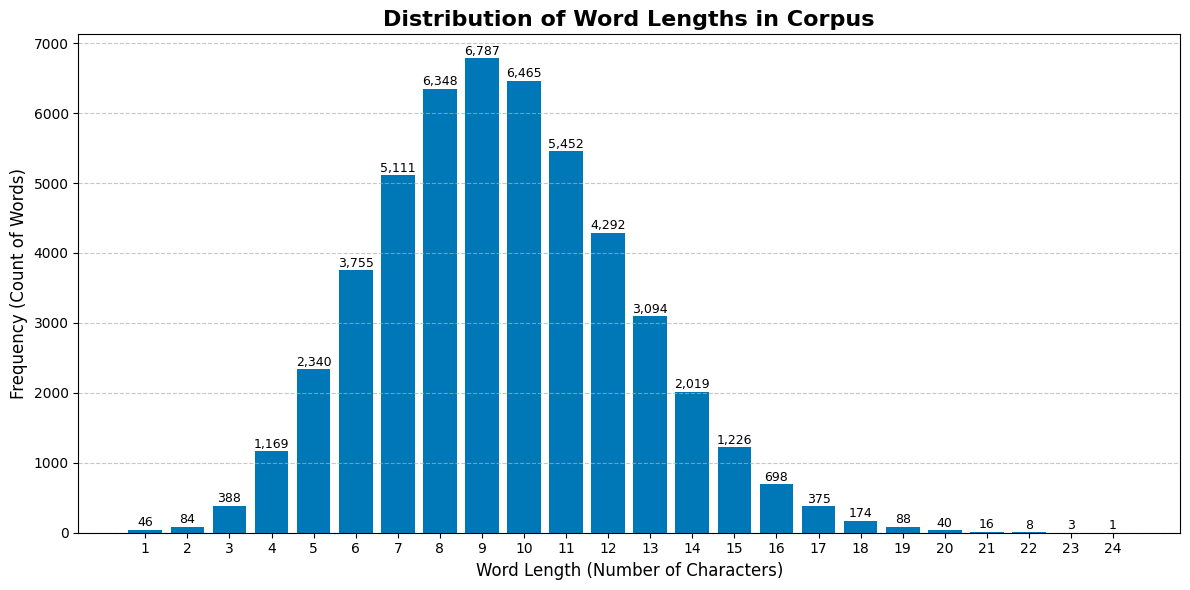

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

# --- 1. Data Preparation: Calculate Word Length Frequencies ---

# The path mentioned in your Colab notebook snippet is:
project_base = '/content/drive/MyDrive/Data'
corpus_path = f'{project_base}/corpus.txt'

try:
    # 1. READ THE CORPUS FILE
    print(f"Attempting to read corpus from: {corpus_path}")

    # Read the file and get a list of all words.
    # The file is typically a list of words, one per line.
    with open(corpus_path, 'r') as f:
        # Strip whitespace (like newline characters) and convert to lowercase
        # Also filter out any empty lines
        words = [word.strip().lower() for word in f if word.strip()]

    print(f"Successfully loaded {len(words):,} words from the corpus.")

except FileNotFoundError:
    print(f"⚠️ Warning: Corpus file not found at {corpus_path}.")
    print("Using mock data to demonstrate the plotting logic.")

    # MOCK DATA (if the file cannot be read in this environment)
    words = [
        "cat", "dog", "run", "jump", "walk", "quick", "brown",
        "fox", "the", "lazy", "over", "hangman", "problem",
        "agent", "algorithm", "python", "data", "test", "hello"
    ]

except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    print("Using mock data to demonstrate the plotting logic.")
    words = [
        "code", "graph", "length", "word", "frequency", "matplotlib"
    ]


# 2. CALCULATE LENGTHS AND FREQUENCIES
# Get the length of every word
word_lengths = [len(word) for word in words]

# Count the frequency of each length
# {3: 3, 4: 5, 5: 2, ...}
length_counts = Counter(word_lengths)

# Convert to sorted lists for plotting
# x-axis: Word Lengths (sorted)
lengths = sorted(length_counts.keys())
# y-axis: Frequencies/Counts
frequencies = [length_counts[length] for length in lengths]


# --- 2. Generate the Bar Chart (Word Length vs. Frequency) ---

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bar chart
bars = ax.bar(lengths, frequencies, color='#0077B6', width=0.8)

# Set labels and title
ax.set_xlabel('Word Length (Number of Characters)', fontsize=12)
ax.set_ylabel('Frequency (Count of Words)', fontsize=12)
ax.set_title('Distribution of Word Lengths in Corpus', fontsize=16, fontweight='bold')

# Customize the x-axis to show every length as a whole number
ax.set_xticks(lengths)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add frequency count on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.,
            height + 5, # Position the text slightly above the bar
            f'{height:,}', # Format the number with a comma for large counts
            ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()